In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the data

# Get current working directory
current_dir = os.getcwd() 

# Append data/mnist.npz to the previous path to get the full path
data_path = "/kaggle/input/rsna-breast-cancer-detection/train_images"

In [4]:
def reshape_and_normalize(images):
    
    # Reshape the images to add an extra dimension
    # images = images[..., np.newaxis]
    
    # Normalize pixel values
    images = images / 255.0
    
    ### END CODE HERE
    return images

In [5]:
train_csv = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_csv = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

In [6]:
train_csv

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [7]:
test_csv

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [8]:
len(set(train_csv.patient_id))

11913

In [9]:
train_csv.laterality.value_counts()

R    27439
L    27267
Name: laterality, dtype: int64

In [10]:
train_subset_0 = train_csv[train_csv.cancer == 0]
train_subset_1 = train_csv[train_csv.cancer == 1]
print(train_subset_0.shape, train_subset_1.shape)
print(train_subset_0.laterality.value_counts())
print(train_subset_1.laterality.value_counts())

(53548, 14) (1158, 14)
R    26869
L    26679
Name: laterality, dtype: int64
L    588
R    570
Name: laterality, dtype: int64


take data subset

In [11]:
train_subset_0_L = train_subset_0[train_subset_0.laterality == "L"].iloc[:588,]
train_subset_0_R = train_subset_0[train_subset_0.laterality == "R"].iloc[:570,]
train_subset_main = pd.concat([train_subset_0_L, train_subset_0_R, train_subset_1])

In [12]:
train_subset_main

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False
54595,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False


In [13]:
train_subset_main.shape

(2316, 14)

In [14]:
os.mkdir('/kaggle/working/input_transformed/')

In [15]:
os.mkdir('/kaggle/working/input_transformed/0/')
os.mkdir('/kaggle/working/input_transformed/1/')

In [16]:
import shutil
from tqdm import tqdm
# shutil.copyfile(src, dst)

In [17]:
p_id = train_subset_main.patient_id
i_id = train_subset_main.image_id
cncr = train_subset_main.cancer
for pp, ii, cc in tqdm(zip(p_id, i_id, cncr)):
    tmpFile = str(pp) + "_" + str(ii) + ".png"
    tmpSrc = "/kaggle/input/rsna-breast-cancer-512-pngs/" + tmpFile
    tmpDst = "/kaggle/working/input_transformed/" + str(cc) + "/" + tmpFile
    shutil.copyfile(tmpSrc, tmpDst)

2316it [00:33, 69.19it/s]


In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/input_transformed/",
    color_mode='rgb',
    image_size=(512, 512),
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=2023)

Found 2316 files belonging to 2 classes.
Using 1853 files for training.


In [19]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/input_transformed/",
    color_mode='rgb',
    image_size=(512, 512),
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=2023)

Found 2316 files belonging to 2 classes.
Using 463 files for validation.


In [20]:
from tensorflow.keras.layers import Dropout

> **#CNN Model**

In [21]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(512, 512, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),  
  layers.MaxPooling2D(),   
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.95:
            print("\nReached 99.5% accuracy so cancelling training!") 
            # Stop training once the above condition is met
            self.model.stop_training = True

In [25]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/5
58/58 [==============================] - 28s 336ms/step - loss: 0.9977 - accuracy: 0.5339 - val_loss: 0.6824 - val_accuracy: 0.5572
Epoch 2/5
58/58 [==============================] - 19s 307ms/step - loss: 0.6581 - accuracy: 0.6233 - val_loss: 0.6906 - val_accuracy: 0.5637
Epoch 3/5
58/58 [==============================] - 19s 305ms/step - loss: 0.5977 - accuracy: 0.6865 - val_loss: 0.7930 - val_accuracy: 0.5529
Epoch 4/5
58/58 [==============================] - 19s 305ms/step - loss: 0.4359 - accuracy: 0.7809 - val_loss: 0.9961 - val_accuracy: 0.5378
Epoch 5/5
58/58 [==============================] - 19s 307ms/step - loss: 0.2463 - accuracy: 0.8918 - val_loss: 1.4845 - val_accuracy: 0.5313


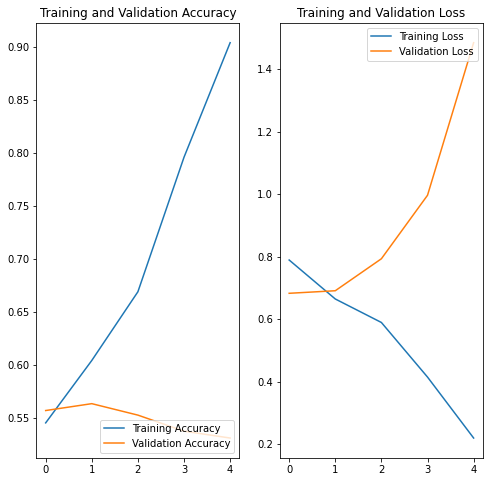

In [26]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [27]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (512, 512, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [28]:
testdata_path = "/kaggle/input/rsna-screen-breast-cancer-detect-testdata-512x512"
pred_dict = dict()
for ii in os.listdir(testdata_path):
    tmpPath = testdata_path + "/" + ii
    image = load(tmpPath)
    predictions = model.predict(image)
    score = tf.nn.softmax(predictions[0])
    pred_dict[ii] = float(max(score))

In [29]:
from pprint import pprint
testD = {"10008_L":{"736471439.png":0, "1591370361.png":0}, 
         "10008_R":{"68070693.png":0,"361203119.png":0}}

for k1 in testD:
    for k2 in testD[k1]:
        testD[k1][k2] = pred_dict[k2]

pprint(testD)

{'10008_L': {'1591370361.png': 0.6729117631912231,
             '736471439.png': 0.5565143823623657},
 '10008_R': {'361203119.png': 0.5560362339019775,
             '68070693.png': 0.9385958313941956}}


In [30]:
submission = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv")
submission

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [31]:
for jj in range(submission.shape[0]):
    tmpKey = submission.prediction_id.iloc[jj]
    submission.cancer.iloc[jj] = np.mean(list(testD[tmpKey].values()))

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [32]:
submission.to_csv("submission.csv")
submission

,prediction_id,cancer
0,10008_L,0.614713
1,10008_R,0.747316
